In [39]:
"""
Alexandre
2024/10/18
"""

# Test the influence of differents parameters of the encoding layer. A) step duration in the input stimulation B) number of neurone int he encoding layer.

'\nAlexandre\n2024/10/18\n'

# **Initial tests**

## Initialisation part

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import nest
import os

In [41]:
cwd = os.getcwd()
print(cwd)

results_fodler_name = "B_results"
os.makedirs(
    os.path.join(cwd, results_fodler_name),
    exist_ok=True
)

/root/EBRAIN-Fall-School/nest_project_eitn_24/Encoding_Layer_Alexandre


## network generation

In [42]:
# general parameters
gamma = 0.25 # relative number of inhibitory

# encoding layer parameters
nEnc = 500  # number of neurons in the encoding layer
J_bias = 200. # [pA]

# main network parameters
NE = 1000 # number of excitatory neurons (10.000 in [1])
CE = 200 # indegree from excitatory neurons

# synapse parameters
w = 0.1 # excitatory synaptic weight (mV)
g = 5. # relative inhibitory to excitatory synaptic weight
d = 1.5 # synaptic transmission delay (ms)

In [43]:
def gen_network(
    gamma=gamma,
    # encoding layer parameters
    nEnc=nEnc,
    J_bias=J_bias,
    # main network parameters
    NE=NE,
    CE=CE, # indegree from excitatory neurons

    # synapse parameters
    w=w, # excitatory synaptic weight (mV)
    g=g, # relative inhibitory to excitatory synaptic weight
    d=d, # synaptic transmission delay (ms)
):
 
    # create the encoding layer
    enc_layer = nest.Create(
        model='iaf_psc_delta', 
        n=nEnc, 
        params={'I_e': J_bias}
    )

    # record the activity of the encoding layer
    enc_spks = nest.Create('spike_recorder')
    nest.Connect(enc_layer, enc_spks)

    ##### MAIN NETWORK #####
    # population parameters
    NI = int(gamma * NE) # number of inhibitory neurons
    CI = int(gamma * CE) # indegree from inhibitory neurons

    # neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }

    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    main_spks = nest.Create('spike_recorder')

    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, main_spks)

    # connect the encoding layer to both neuronal population
    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

    return enc_layer, enc_spks, main_spks

In [44]:
# set general parameters
seed = 1
dt = 0.1 #dt = 1.
num_threads = 16

# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network()


Oct 21 17:22:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


## generate input and connect it to the network

In [45]:
# import librairies input stimulus generator
from utils.inputs import generate_piecewise_constant_signal

In [46]:
# encoding layer parameters
nEnc = 500 # number of neurons in the encoding layer

# stimulus parameters
step_duration = 20. # [ms]
scale = 1. # input scaling factor [Hz]
num_steps = 100 # number of unique input values

In [47]:
def gen_input(
    # encoding layer parameters
    nEnc=nEnc,  # number of neurons in the encoding layer

    # stimulus parameters
    step_duration=step_duration, # [ms]
    scale=scale, # input scaling factor [Hz]
    num_steps=num_steps, # number of unique input values
):
    
    # encoding layer reparametrisation
    tuning = 250. * np.random.randn(nEnc) + 1000. # 
    thresholds = 5 * np.random.randn(nEnc) - 50. # generate some heterogeneity on the population
    thresholds = np.maximum(thresholds, -65.) # 
    Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc))) # randomized initiate point of each neuron

    # generation of the stimulus
    sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
        seed=seed, 
        num_steps=num_steps,
        step_duration=step_duration, 
        resolution=dt, 
        scale=scale
        )
    sig = sig/2.
    step_generator = nest.Create(
        model='step_current_generator', 
        n=nEnc
    )
    amplitudes = np.zeros((nEnc, len(inp_amplitudes)))

    for n in range(nEnc): # for each neuron in the encoding layer
        
        # transform the input as function of the tuning of each neuron
        amplitudes[n, :] = inp_amplitudes * tuning[n]
        
        # change parameters of each neuron in the input layer
        enc_layer[n].set(
            {
                'V_m': Vm0[n], # set the membrane potential initialisation
                'V_th': thresholds[n] # set the excitation threshold
            }
        )

        # change caracteristics of the input generator
        step_generator[n].set(
            {
                'amplitude_times': inp_times, # set the time
                'amplitude_values': amplitudes[n] # set the amplitude
            }
        )

        # connect the input generator to the encoding layer neuron one-by-one
        nest.Connect(
            step_generator[n],
            enc_layer[n]
        )
    
    return sig, times, inp_times, inp_amplitudes

In [48]:
sig, times, inp_times, inp_amplitudes = gen_input()

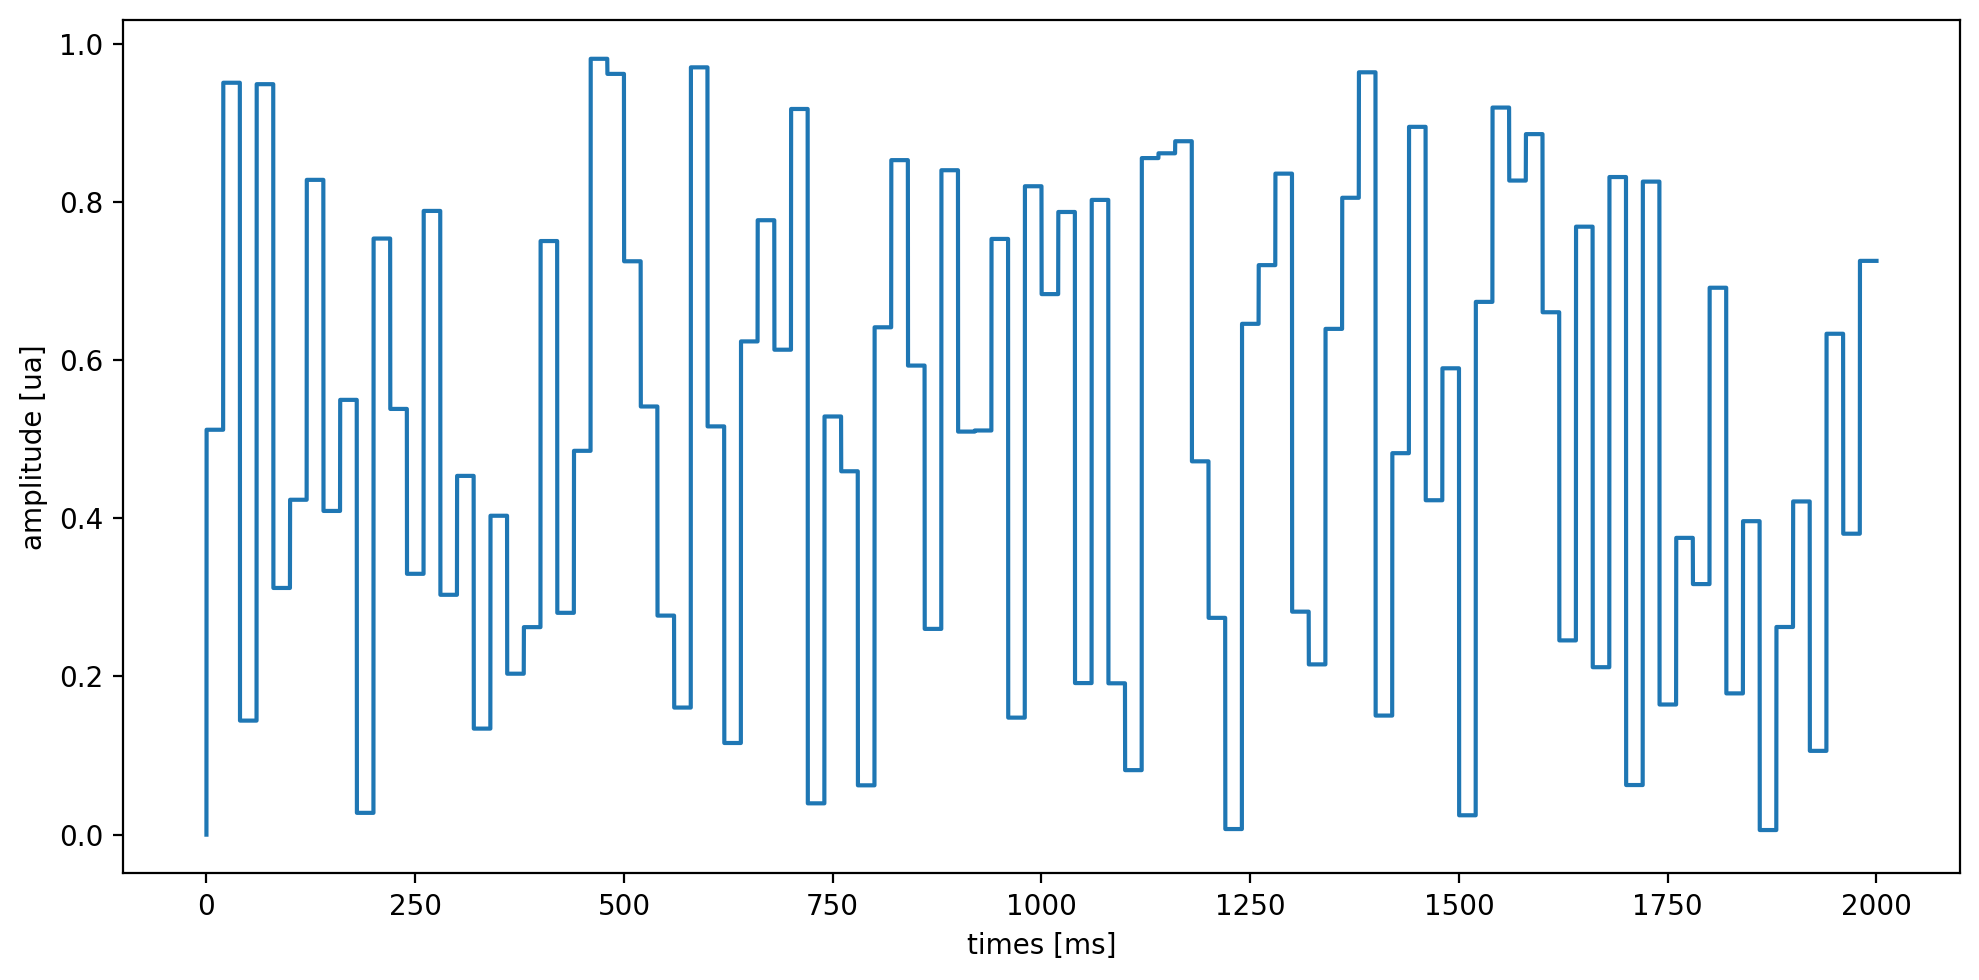

In [49]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(10,5),
    dpi=200
)

ax.plot(
    times,
    sig
)
ax.set_xlabel("times [ms]")
ax.set_ylabel("amplitude [ua]")

plt.tight_layout()
plt.show()

## extract simulation results

In [50]:
# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)

# extract the simulation results
from utils.extractors import filter_spikes_parallel

filter_tau = 20. # [ms]


Oct 21 17:22:14 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:22:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:22:17 SimulationManager::run [Info]: 
    Simulation finished.


In [51]:
def extract_results(
        enc_spks=enc_spks,
        main_spks=main_spks,
        filter_tau=filter_tau,
        sim_time=sim_time,
        nEnc=nEnc, NE=NE,
        dt=dt,
        num_threads=num_threads

):
    
    enc_activity = enc_spks.events
    enc_states = filter_spikes_parallel(
        enc_activity['times'], enc_activity['senders'], # use the timing and the origin of each spike of the encoding layer
        nEnc, # total number of neuron in the encoding layer
        t_start=0., t_stop=sim_time, dt=dt, # begin, end and time-step of the simulation
        tau=filter_tau, 
        n_processes=num_threads
    )

    main_activity = main_spks.events
    main_states = filter_spikes_parallel(
        main_activity['times'], main_activity['senders'], 
        NE, 
        t_start=0., t_stop=sim_time, dt=dt, 
        tau=filter_tau, 
        n_processes=num_threads
    )

    return enc_activity, enc_states, main_activity, main_states

In [52]:
enc_activity, enc_states, main_activity, main_states = extract_results()

Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 63.90it/s]


## decoding the activity

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
def compute_capacity(x, z):
    """
    Compute capacity to reconstruct z based on linearly combining x

    Parameters
    ----------
    x : np.ndarray
        state matrix(NxT)
    z : np.ndarray
        target output (1xT)

    Returns
    -------
    z_hat : np.ndarray
        Reconstructed (predicted) signal

    """
    reg = LinearRegression(
        n_jobs=-1, 
        fit_intercept=False
    ).fit(x.T, z)
    
    W_out = reg.coef_
    z_hat = np.dot(W_out, x)

    covs = np.cov(z_hat, z)[0, 1] ** 2.0
    vars = np.var(z) * np.var(z_hat)
    capacity = covs / vars

    error = np.mean((z - z_hat) ** 2)
    return z_hat, capacity, error

In [55]:
enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")

Encoding Layer: 
	- Capacity=0.5225698042779324, MSE=0.03941408261170647
Main Circuit: 
	- Capacity=0.5702694715459922, MSE=0.03714442253361304


In [56]:
from utils.capacity import compute_capacity_sequential

In [57]:
subsampling_factor = 1 # ms
max_lag = 100 # ms
step_lag = 10.0 / subsampling_factor

In [58]:
time_capacity, encoder_capacity, main_capacity = compute_capacity_sequential(
    time_vector=times,
    signal=sig[1:], 
    enc_states=enc_states,
    ex_states=main_states,
    subsampling_factor=subsampling_factor,
    max_lag=max_lag,
    dt=dt
)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.5225698042779324, MSE=0.03941408261170647
Main Circuit: 
	- Capacity=0.5702694715459922, MSE=0.03714442253361304
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.7275310079553022, MSE=0.0225102015960887
Main Circuit: 
	- Capacity=0.7908651664617152, MSE=0.01771447941420252
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.5305051646786901, MSE=0.03887043987548441
Main Circuit: 
	- Capacity=0.6774388693829153, MSE=0.026712871442480027
Lag = 30.0 ms
Encoding Layer: 
	- Capacity=0.23335101866055483, MSE=0.06371463011714568
Main Circuit: 
	- Capacity=0.5041491349742283, MSE=0.04313160019702034
Lag = 40.0 ms
Encoding Layer: 
	- Capacity=0.20210834941103742, MSE=0.0665921579691475
Main Circuit: 
	- Capacity=0.551187582507638, MSE=0.0396443754035139
Lag = 50.0 ms
Encoding Layer: 
	- Capacity=0.1710447758358969, MSE=0.06945850390867896
Main Circuit: 
	- Capacity=0.5417657706907276, MSE=0.039674712235115116
Lag = 60.0 ms
Encoding Layer: 
	- Capacity=0.20810731

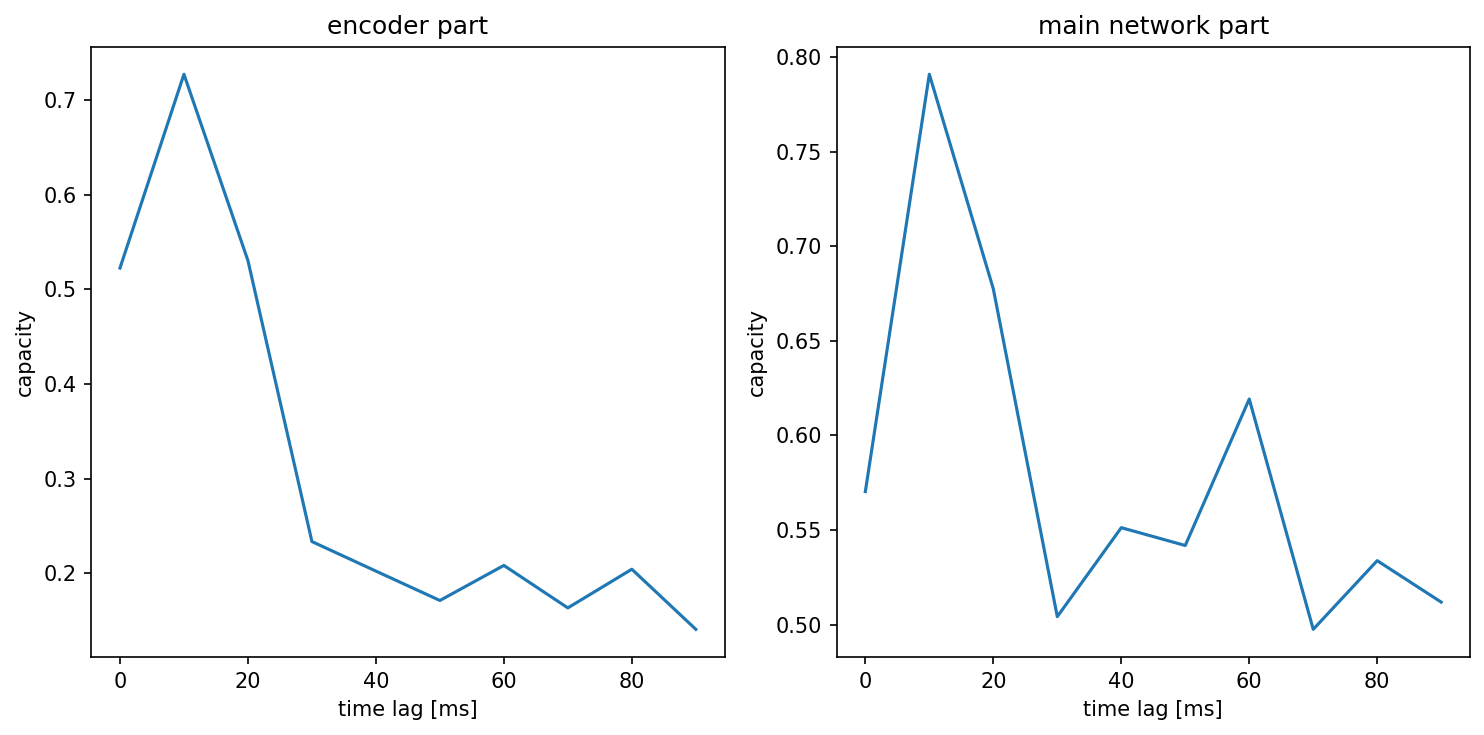

Total capacity (encoder): 31.030425087571274
Total capacity (processor): 57.978857345175015 ms


In [59]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,5),
    dpi=150
)

ax[0].plot(
    time_capacity,
    encoder_capacity
)
ax[0].set_title("encoder part")
ax[0].set_ylabel("capacity")
ax[0].set_xlabel("time lag [ms]")

ax[1].plot(
    time_capacity,
    main_capacity
)
ax[1].set_title("main network part")
ax[1].set_ylabel("capacity")
ax[1].set_xlabel("time lag [ms]")

plt.tight_layout()
plt.show()

print(f"Total capacity (encoder): {np.sum(encoder_capacity)*step_lag}")
print(f"Total capacity (processor): {np.sum(main_capacity)*step_lag} ms")

## run simulation

In [60]:
# initialize nest kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})

# generate the network
enc_layer, enc_spks, main_spks = gen_network(
    gamma=gamma,
    nEnc=nEnc,
    J_bias=J_bias,
    NE=NE, CE=CE,
    w=w, g=g, d=d
)

# generation input and connect it to the network
sig, times, inp_times, inp_amplitudes = gen_input(
    nEnc=nEnc,
    step_duration=step_duration,
    num_steps=num_steps
)

# run the simulation
sim_time = num_steps*step_duration
nest.Simulate(sim_time)

# results extraction
enc_activity, enc_states, main_activity, main_states = extract_results(
    enc_spks=enc_spks,
    main_spks=main_spks,
    filter_tau=filter_tau,
    nEnc=nEnc, NE=NE
)

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

print(f"Encoding Layer: \n\t- Capacity={enc_capacity}, MSE={enc_error}")
print(f"Main Circuit: \n\t- Capacity={main_capacity}, MSE={main_error}")


Oct 21 17:22:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:22:59 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:22:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:23:02 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 63.64it/s]


Encoding Layer: 
	- Capacity=0.5363619495489882, MSE=0.03825479709615963
Main Circuit: 
	- Capacity=0.5666683729695962, MSE=0.03771630105928146


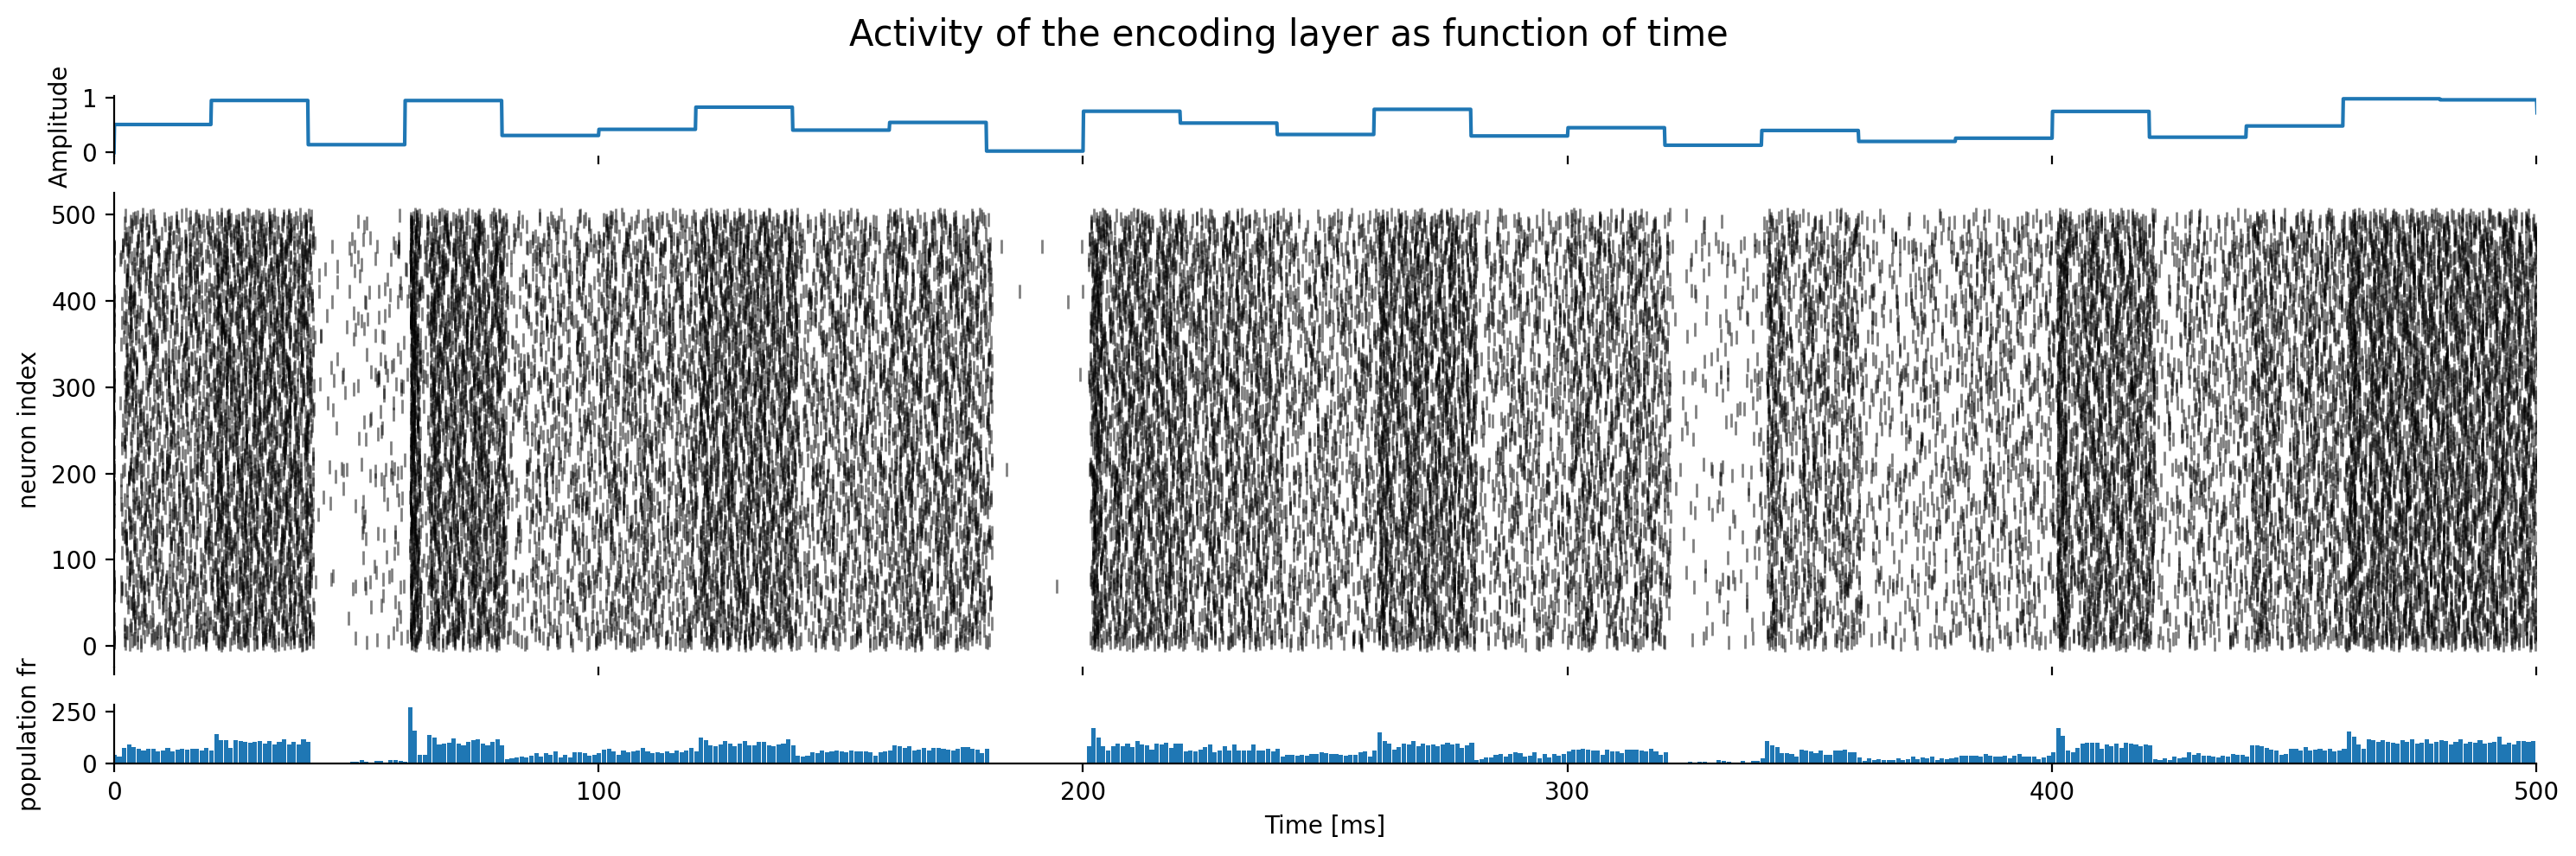

In [61]:
# graphical representation of the encoding layer spiking activity
fig,ax = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.1,0.8,0.1]},
    sharex=True
)

ax[0].plot(
    times,
    sig
)

ax[1].plot(
    enc_spks.events["times"],
    enc_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    enc_spks.events["times"],
    bins=np.linspace(
        enc_spks.events["times"].min(), 
        enc_spks.events["times"].max(), 
        int(enc_spks.events["times"].max())
    )
)

ax[2].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 500)
ax[0].set_ylabel(r'Amplitude')
ax[0].spines[["top","right","bottom"]].set_visible(False)

ax[1].set_ylabel(r"neuron index")
ax[1].spines[["top","bottom","right"]].set_visible(False)

ax[2].set_ylabel(r"population fr")
ax[2].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the encoding layer as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_encoding_layer.pdf"), dpi=200)
plt.show()

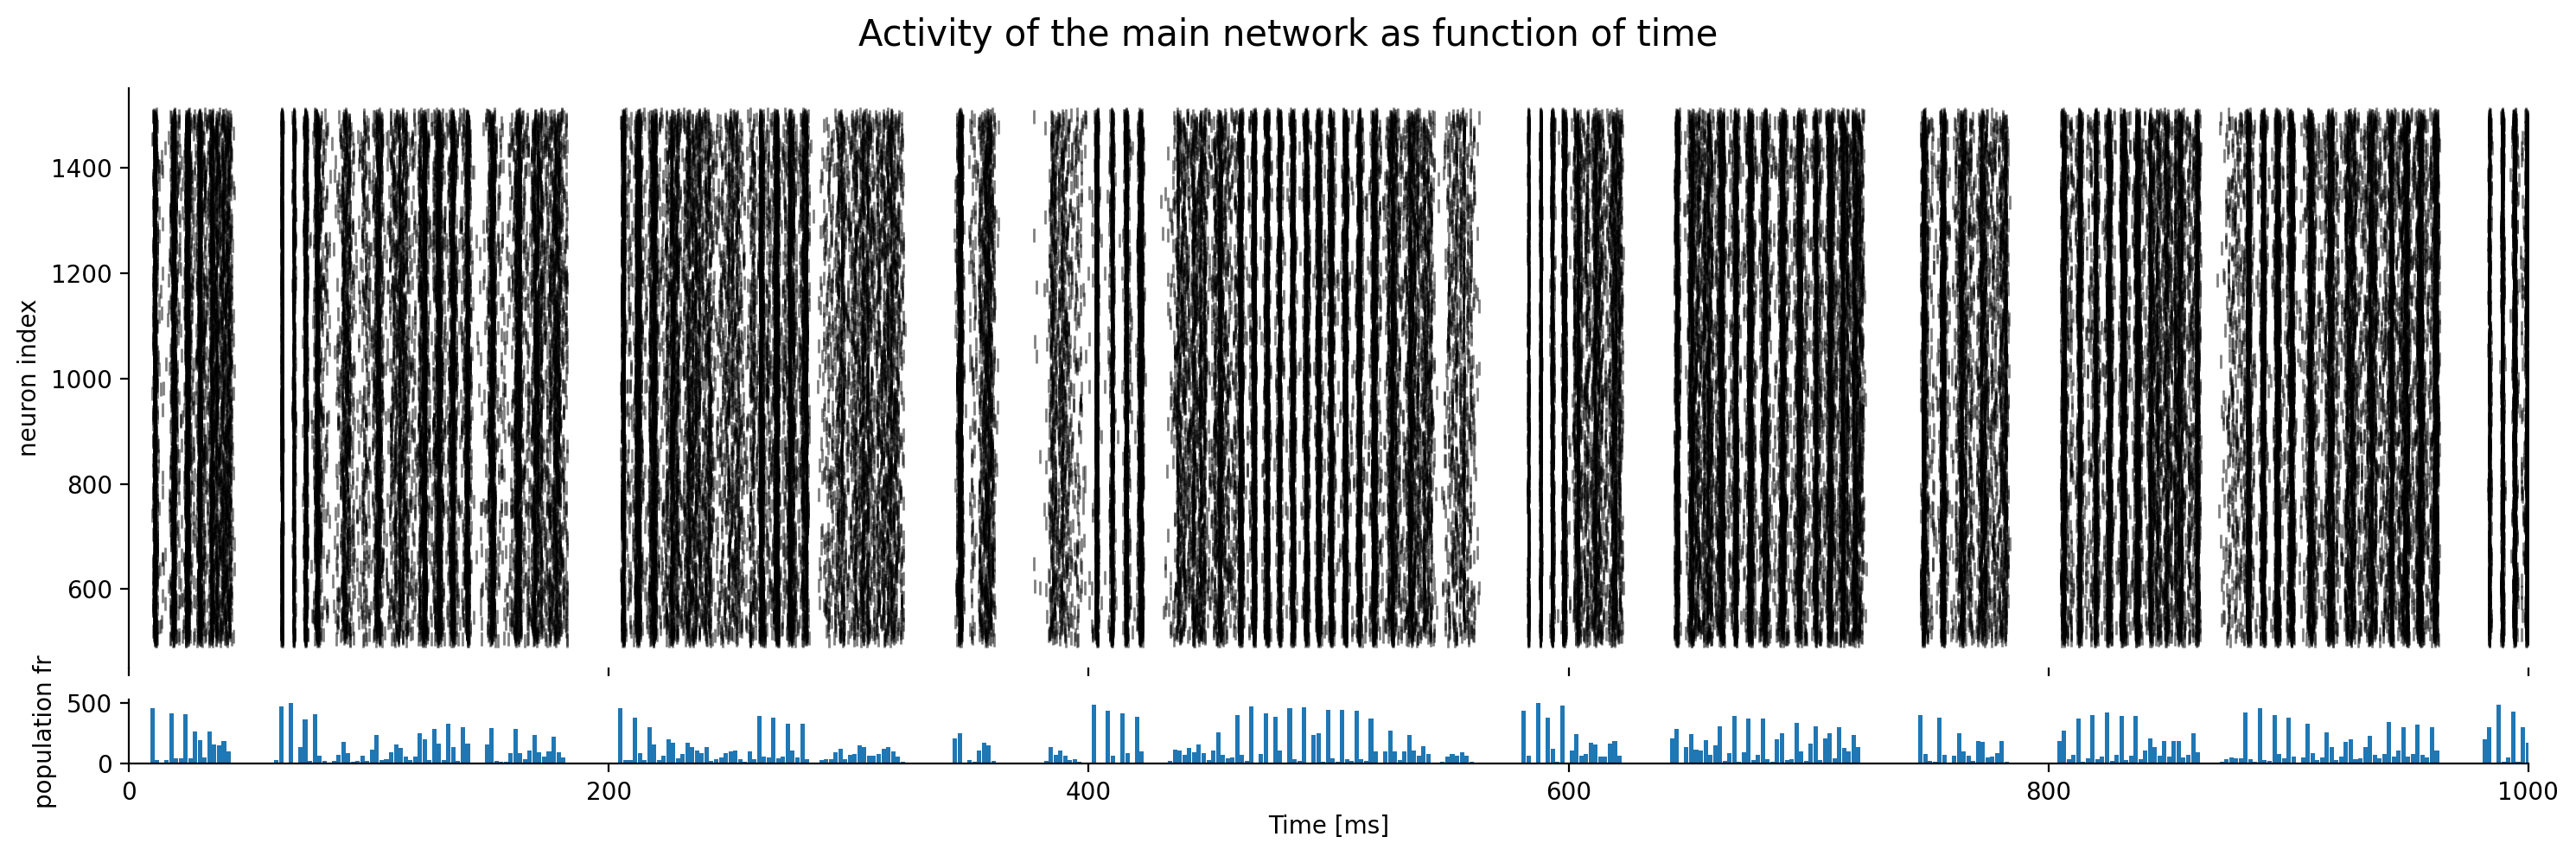

In [62]:
# graphical representation of the main network
fig,ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15,5),
    dpi=200,
    gridspec_kw={"height_ratios":[0.9,0.1]},
    sharex=True
)

ax[0].plot(
    main_spks.events["times"],
    main_spks.events["senders"],
    "|", color="black",
    # markersize=1,
    alpha=0.5
)

values, bins = np.histogram(
    main_spks.events["times"],
    bins=np.linspace(main_spks.events["times"].min(), main_spks.events["times"].max(), 1_000)
)

ax[1].bar(
    x=bins[:-1],
    height=values/(bins[1]-bins[0]),
    width=(bins[1]-bins[0])/1.1
)

ax[0].set_xlim(0, 1_000)
ax[0].set_ylabel(r"neuron index")
ax[0].spines[["top","bottom","right"]].set_visible(False)

ax[1].set_ylabel(r"population fr")
ax[1].spines[["top","right"]].set_visible(False)

ax[-1].set_xlabel(r'Time [ms]')

fig.suptitle("Activity of the main network as function of time", size=15)

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "activity_main_network.pdf"), dpi=200)
plt.show()

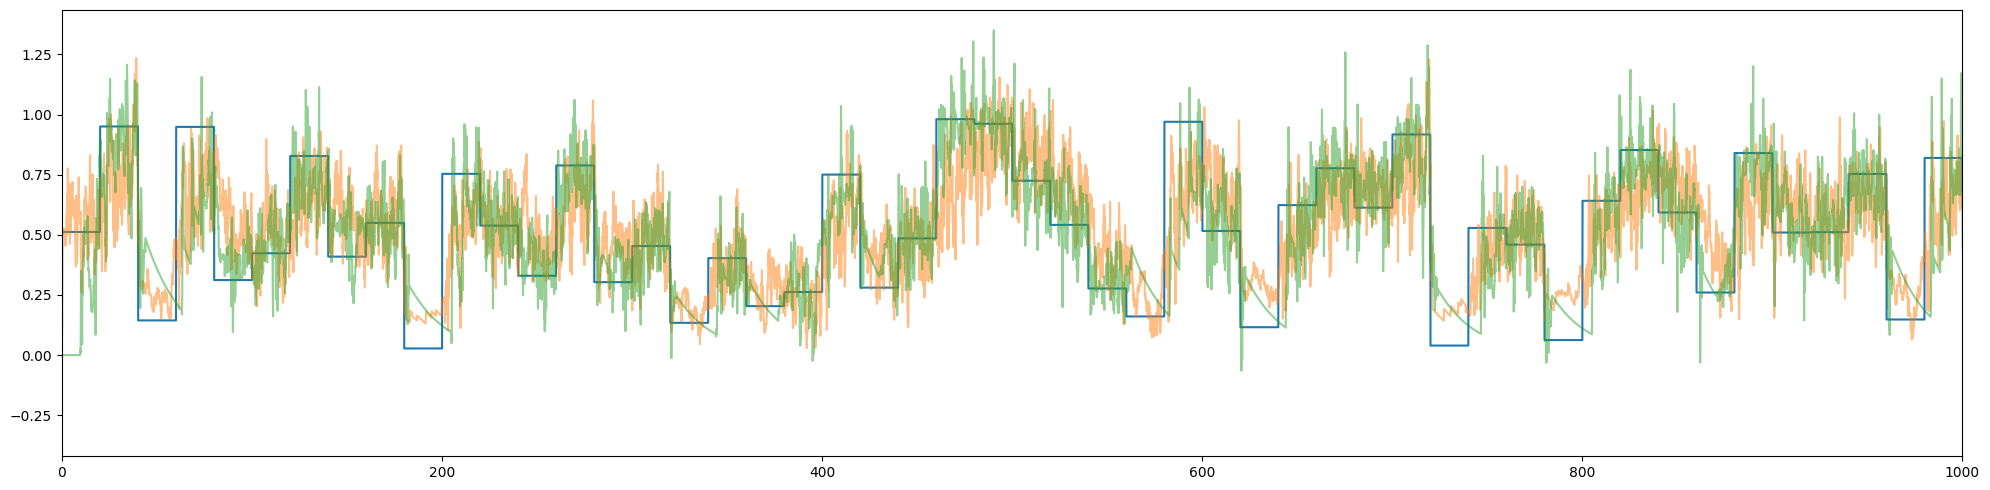

In [63]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(20,5)
)

ax.plot(
    times,
    sig
)

ax.plot(
    times[:-1],
    enc_estimate,
    alpha=0.5   
)

ax.plot(
    times[:-1],
    main_estimate,
    alpha=0.5   
)

ax.set_xlim(0,1_000)

plt.tight_layout()
plt.show()

## influence of the step duration

In [82]:
step_duration_range = np.linspace(0, 100, 51)[1:]
print(step_duration_range)

[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.
  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.
  86.  88.  90.  92.  94.  96.  98. 100.]


In [83]:
for step_dur in step_duration_range:

    if os.path.exists(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")):
        print("Already compute !")
        
    else:
        # initialize nest kernel
        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        # generate the network
        enc_layer, enc_spks, main_spks = gen_network(
            gamma=gamma,
            nEnc=nEnc,
            J_bias=J_bias,
            NE=NE, CE=CE,
            w=w, g=g, d=d
        )

        # generation input and connect it to the network
        sig, times, inp_times, inp_amplitudes = gen_input(
            nEnc=nEnc,
            scale=scale,
            step_duration=step_dur,
            num_steps=num_steps,
        )

        # run the simulation
        sim_time = num_steps * step_dur
        nest.Simulate(sim_time)

        # results extraction
        enc_activity, enc_states, main_activity, main_states = extract_results(
            enc_spks=enc_spks,
            main_spks=main_spks,
            filter_tau=filter_tau,
            nEnc=nEnc, NE=NE,
            sim_time=sim_time
        )

        print(sig[1:].shape, enc_states.shape)
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

        np.save(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}"), main_error)
        np.save(os.path.join(results_fodler_name, "step_duration", f"main_estimate_stepdur_{step_dur}"), main_estimate)


Oct 21 17:25:23 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:25:23 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:25:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:25:24 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:01<00:00, 649.41it/s]


(2000,) (500, 2000)

Oct 21 17:25:27 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:25:27 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:25:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:25:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:03<00:00, 322.50it/s]


(4000,) (500, 4000)

Oct 21 17:25:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:25:34 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:25:34 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:25:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:04<00:00, 209.80it/s]


(6000,) (500, 6000)

Oct 21 17:25:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:25:44 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:25:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:25:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:06<00:00, 163.27it/s]


(8000,) (500, 8000)

Oct 21 17:25:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:25:56 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:25:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:25:57 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:07<00:00, 129.47it/s]


(10000,) (500, 10000)

Oct 21 17:26:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:26:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:26:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:26:12 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 108.79it/s]


(12000,) (500, 12000)

Oct 21 17:26:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:26:28 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:26:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:26:30 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 93.31it/s]


(14000,) (500, 14000)

Oct 21 17:26:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:26:48 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:26:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:26:51 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:12<00:00, 80.18it/s]


(16000,) (500, 16000)

Oct 21 17:27:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:27:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:27:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 1800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:27:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:13<00:00, 72.34it/s]


(18000,) (500, 18000)

Oct 21 17:27:37 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:27:37 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:27:37 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:27:40 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:15<00:00, 64.34it/s]


(20000,) (500, 20000)

Oct 21 17:28:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:28:06 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:28:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:28:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:16<00:00, 59.51it/s]


(22000,) (500, 22000)

Oct 21 17:28:36 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:28:36 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:28:36 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:28:40 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:18<00:00, 54.00it/s]


(24000,) (500, 24000)

Oct 21 17:29:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:29:11 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:29:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:29:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s]


(26000,) (500, 26000)

Oct 21 17:29:48 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:29:48 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:29:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 2800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:29:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:22<00:00, 44.30it/s]


(28000,) (500, 28000)

Oct 21 17:30:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:30:30 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:30:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 3000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:30:34 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:23<00:00, 41.71it/s]


(30000,) (500, 30000)

Oct 21 17:31:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:31:26 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:31:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 3200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:32:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:42<00:00, 23.39it/s]


(32000,) (500, 32000)

Oct 21 17:36:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:36:07 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:36:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 3400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:36:38 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:26<00:00, 37.65it/s]


(34000,) (500, 34000)

Oct 21 17:37:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:37:22 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:37:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 3600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:37:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:27<00:00, 36.55it/s]


(36000,) (500, 36000)

Oct 21 17:38:12 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:38:12 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:38:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 3800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:38:17 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:36<00:00, 27.48it/s]


(38000,) (500, 38000)

Oct 21 17:42:09 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:42:19 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:42:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 4000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:43:55 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:50<00:00, 19.98it/s]


(40000,) (500, 40000)

Oct 21 17:48:17 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:48:27 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:48:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 4200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:49:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:32<00:00, 31.17it/s]


(42000,) (500, 42000)

Oct 21 17:50:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:50:38 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:50:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 4400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:50:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:34<00:00, 29.14it/s]


(44000,) (500, 44000)

Oct 21 17:51:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:51:41 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:51:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 4600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:51:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:35<00:00, 28.17it/s]


(46000,) (500, 46000)

Oct 21 17:52:45 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:52:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:52:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 4800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:52:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:39<00:00, 25.56it/s]


(48000,) (500, 48000)

Oct 21 17:53:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:53:54 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:53:54 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:54:02 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:40<00:00, 24.71it/s]


(50000,) (500, 50000)

Oct 21 17:55:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:55:06 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:55:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 5200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:55:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:40<00:00, 24.68it/s]


(52000,) (500, 52000)

Oct 21 17:56:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:56:20 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:56:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 5400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:56:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:42<00:00, 23.54it/s]


(54000,) (500, 54000)

Oct 21 17:57:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:57:38 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:57:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 5600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:57:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:48<00:00, 20.48it/s]


(56000,) (500, 56000)

Oct 21 17:59:04 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 17:59:04 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 17:59:05 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 5800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 17:59:14 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:46<00:00, 21.65it/s]


(58000,) (500, 58000)

Oct 21 18:00:28 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:00:28 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:00:28 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 6000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:00:39 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:46<00:00, 21.37it/s]


(60000,) (500, 60000)

Oct 21 18:01:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:01:56 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:01:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 6200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:02:04 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:48<00:00, 20.61it/s]


(62000,) (500, 62000)

Oct 21 18:03:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:03:23 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:03:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 6400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:03:32 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:49<00:00, 20.13it/s]


(64000,) (500, 64000)

Oct 21 18:04:52 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:04:52 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:04:52 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 6600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:05:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:52<00:00, 19.08it/s]


(66000,) (500, 66000)

Oct 21 18:06:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:06:26 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:06:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 6800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:06:35 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:51<00:00, 19.34it/s]


(68000,) (500, 68000)

Oct 21 18:07:59 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:07:59 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:07:59 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 7000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:08:11 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:55<00:00, 18.04it/s]


(70000,) (500, 70000)

Oct 21 18:09:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:09:40 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:09:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 7200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:09:51 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:57<00:00, 17.29it/s]


(72000,) (500, 72000)

Oct 21 18:11:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:11:25 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:11:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 7400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:11:37 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:58<00:00, 17.13it/s]


(74000,) (500, 74000)

Oct 21 18:13:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:13:12 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:13:12 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 7600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:13:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:58<00:00, 17.08it/s]


(76000,) (500, 76000)

Oct 21 18:15:02 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:15:02 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:15:02 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 7800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:15:15 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:09<00:00, 14.48it/s]


(78000,) (500, 78000)

Oct 21 18:17:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:17:27 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:17:27 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 8000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:17:38 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:03<00:00, 15.83it/s]


(80000,) (500, 80000)

Oct 21 18:19:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:19:51 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:19:51 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 8200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:20:04 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:05<00:00, 15.33it/s]


(82000,) (500, 82000)

Oct 21 18:22:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:22:15 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:22:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 8400
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:22:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


(84000,) (500, 84000)

Oct 21 18:25:15 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:25:15 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:25:15 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 8600
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:25:32 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:23<00:00, 12.04it/s]


(86000,) (500, 86000)

Oct 21 18:27:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:27:38 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:27:38 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 8800
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:27:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:09<00:00, 14.42it/s]


(88000,) (500, 88000)

Oct 21 18:29:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:29:45 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:29:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 9000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:30:00 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [01:12<00:00, 13.86it/s]


(90000,) (500, 90000)

Oct 21 18:31:57 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 18:31:57 NodeManager::prepare_nodes [Info]: 
    Preparing 9782 nodes for simulation.

Oct 21 18:31:57 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9782
    Simulation time (ms): 9200
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 18:32:13 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains:   6%|▌         | 28/500 [00:02<00:42, 11.00it/s]


KeyboardInterrupt: 

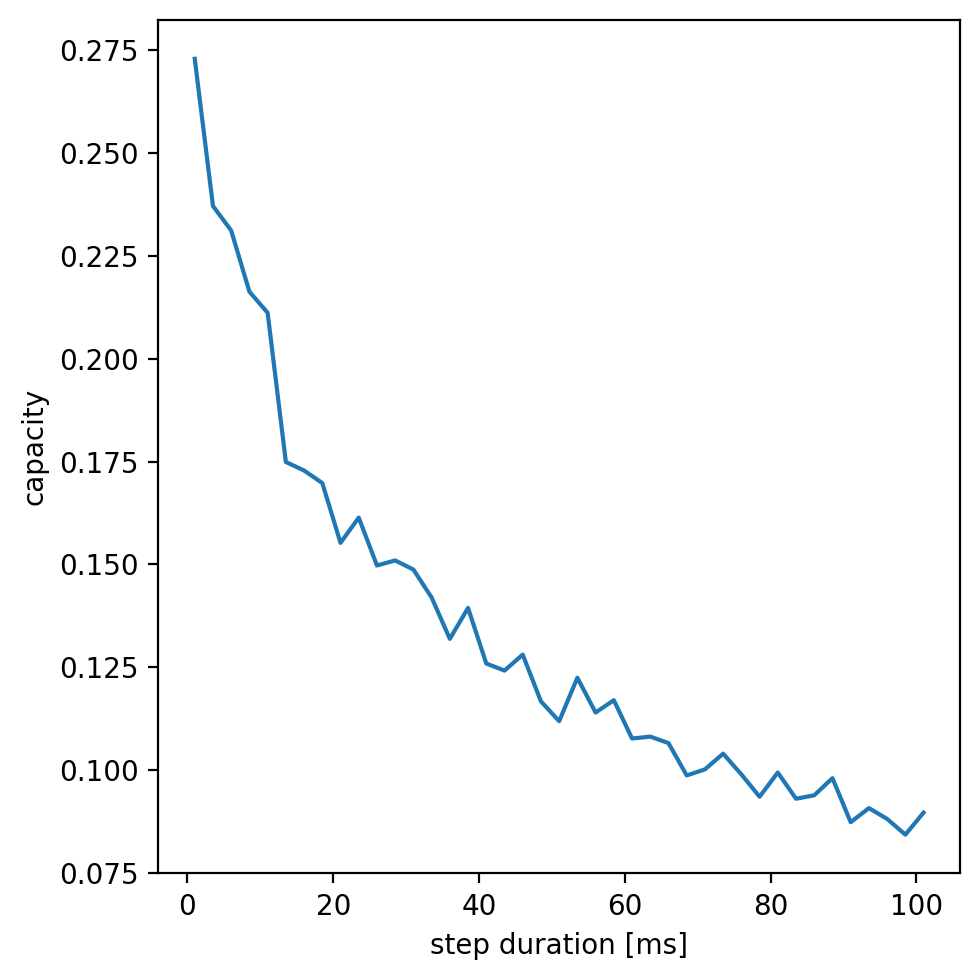

In [24]:
main_capacity = [np.load(os.path.join(results_fodler_name, "step_duration", f"main_capacity_stepdur_{step_dur}.npy")).item() for step_dur in step_duration_range]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.plot(
    step_duration_range,
    main_capacity
)

ax.set_ylabel("capacity")
ax.set_xlabel("step duration [ms]")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "step_duration_influence.pdf"), dpi=200)
plt.show()


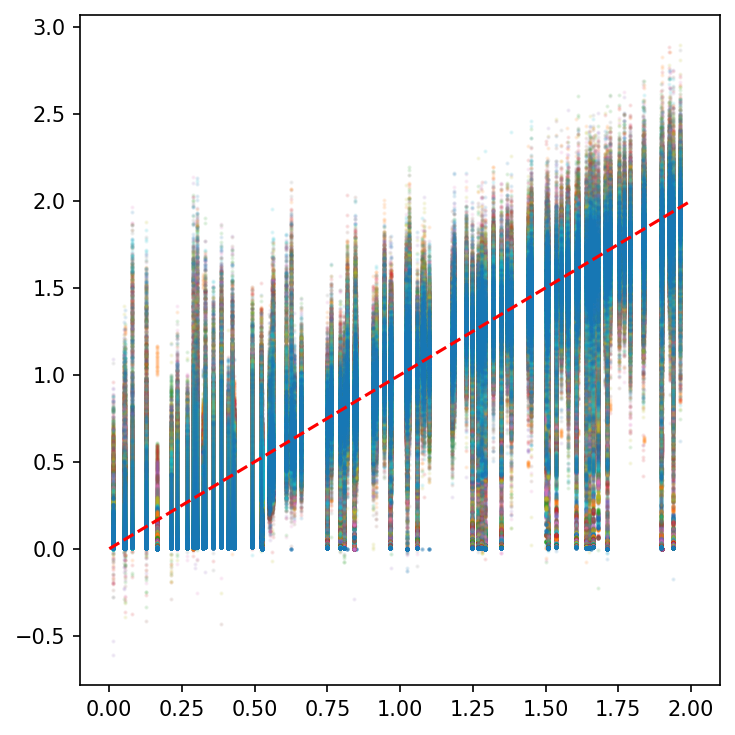

In [40]:
fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=150
)
for step_dur in step_duration_range:

    estimate = np.load(os.path.join(results_fodler_name, "step_duration", f"main_estimate_stepdur_{step_dur}.npy"))

    sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(
        seed=seed, 
        num_steps=num_steps,
        step_duration=step_dur, 
        resolution=dt, 
        scale=scale
        )
    
    ax.scatter(
        x=sig[1:], 
        y=estimate,
        # color="black",
        alpha=0.1,
        s=1
    )

ax.plot(
    [0,2],
    [0,2],
    color="red",
    linestyle="dashed"
)

plt.tight_layout()
plt.show()

## change the number of neuron in the encoding layer

In [59]:
nEnc_range = np.linspace(10, 1_000, 50, dtype=int)
print(nEnc_range)

[  10   30   50   70   90  111  131  151  171  191  212  232  252  272
  292  313  333  353  373  393  414  434  454  474  494  515  535  555
  575  595  616  636  656  676  696  717  737  757  777  797  818  838
  858  878  898  919  939  959  979 1000]


In [60]:
step_duration = 10.
num_steps = 100

In [61]:
for numEnc in nEnc_range:

    if os.path.exists(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}.npy")):
        print("Already compute !")
        
    else:
    
        sim_time = num_steps * step_duration

        # initialize nest kernel
        nest.ResetKernel()
        nest.SetKernelStatus({
            'rng_seed': seed,
            'resolution': dt,
            'local_num_threads': num_threads
        })

        # generate the network
        enc_layer, enc_spks, main_spks = gen_network(
            gamma=gamma,
            nEnc=numEnc,
            J_bias=J_bias,
            NE=NE, CE=CE,
            w=w, g=g, d=d
        )

        # generation input and connect it to the network
        sig, times, inp_times, inp_amplitudes = gen_input(
            nEnc=numEnc,
            scale=scale,
            step_duration=step_duration,
            num_steps=num_steps,
        )

        # run the simulation
        nest.Simulate(sim_time)

        # results extraction
        enc_activity, enc_states, main_activity, main_states = extract_results(
            enc_spks=enc_spks,
            main_spks=main_spks,
            filter_tau=filter_tau,
            nEnc=numEnc, NE=NE,
            sim_time=sim_time
        )

        print(sig[1:].shape, enc_states.shape)
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, sig[1:])
        main_estimate, main_capacity, main_error = compute_capacity(main_states, sig[1:])

        np.save(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}"), main_error)
        np.save(os.path.join(results_fodler_name, "num_encneuron", f"main_estimate_numencneuron_{numEnc}"), main_estimate)

Already compute !

Oct 21 12:01:06 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:01:06 NodeManager::prepare_nodes [Info]: 
    Preparing 1808 nodes for simulation.

Oct 21 12:01:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1808
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:01:07 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 101.44it/s]


(10000,) (30, 10000)

Oct 21 12:01:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:01:18 NodeManager::prepare_nodes [Info]: 
    Preparing 2148 nodes for simulation.

Oct 21 12:01:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2148
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:01:19 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.94it/s]


(10000,) (50, 10000)

Oct 21 12:01:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:01:30 NodeManager::prepare_nodes [Info]: 
    Preparing 2488 nodes for simulation.

Oct 21 12:01:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2488
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:01:31 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.89it/s]


(10000,) (70, 10000)

Oct 21 12:01:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:01:44 NodeManager::prepare_nodes [Info]: 
    Preparing 2828 nodes for simulation.

Oct 21 12:01:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2828
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:01:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.76it/s]


(10000,) (90, 10000)

Oct 21 12:01:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:01:56 NodeManager::prepare_nodes [Info]: 
    Preparing 3185 nodes for simulation.

Oct 21 12:01:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3185
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:01:56 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.84it/s]


(10000,) (111, 10000)

Oct 21 12:02:11 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:02:11 NodeManager::prepare_nodes [Info]: 
    Preparing 3525 nodes for simulation.

Oct 21 12:02:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3525
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:02:12 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 94.05it/s]


(10000,) (131, 10000)

Oct 21 12:02:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:02:26 NodeManager::prepare_nodes [Info]: 
    Preparing 3865 nodes for simulation.

Oct 21 12:02:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3865
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:02:27 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.35it/s]


(10000,) (151, 10000)

Oct 21 12:02:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:02:39 NodeManager::prepare_nodes [Info]: 
    Preparing 4205 nodes for simulation.

Oct 21 12:02:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4205
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:02:40 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.45it/s]


(10000,) (171, 10000)

Oct 21 12:02:53 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:02:53 NodeManager::prepare_nodes [Info]: 
    Preparing 4545 nodes for simulation.

Oct 21 12:02:53 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4545
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:02:54 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 96.86it/s]


(10000,) (191, 10000)

Oct 21 12:03:08 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:03:08 NodeManager::prepare_nodes [Info]: 
    Preparing 4902 nodes for simulation.

Oct 21 12:03:08 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 4902
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:03:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 95.12it/s]


(10000,) (212, 10000)

Oct 21 12:03:24 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:03:25 NodeManager::prepare_nodes [Info]: 
    Preparing 5242 nodes for simulation.

Oct 21 12:03:25 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5242
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:03:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 94.56it/s]


(10000,) (232, 10000)

Oct 21 12:03:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:03:42 NodeManager::prepare_nodes [Info]: 
    Preparing 5582 nodes for simulation.

Oct 21 12:03:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5582
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:03:43 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 96.56it/s]


(10000,) (252, 10000)

Oct 21 12:04:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:04:00 NodeManager::prepare_nodes [Info]: 
    Preparing 5922 nodes for simulation.

Oct 21 12:04:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5922
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:04:02 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.15it/s]


(10000,) (272, 10000)

Oct 21 12:04:16 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:04:16 NodeManager::prepare_nodes [Info]: 
    Preparing 6262 nodes for simulation.

Oct 21 12:04:16 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6262
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:04:18 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 97.25it/s]


(10000,) (292, 10000)

Oct 21 12:04:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:04:33 NodeManager::prepare_nodes [Info]: 
    Preparing 6619 nodes for simulation.

Oct 21 12:04:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6619
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:04:34 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:10<00:00, 99.27it/s]


(10000,) (313, 10000)

Oct 21 12:04:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:04:49 NodeManager::prepare_nodes [Info]: 
    Preparing 6959 nodes for simulation.

Oct 21 12:04:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6959
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:04:50 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 100.13it/s]


(10000,) (333, 10000)

Oct 21 12:05:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:05:06 NodeManager::prepare_nodes [Info]: 
    Preparing 7299 nodes for simulation.

Oct 21 12:05:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7299
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:05:07 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.24it/s]


(10000,) (353, 10000)

Oct 21 12:05:22 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:05:22 NodeManager::prepare_nodes [Info]: 
    Preparing 7639 nodes for simulation.

Oct 21 12:05:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7639
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:05:24 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 101.28it/s]


(10000,) (373, 10000)

Oct 21 12:05:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:05:39 NodeManager::prepare_nodes [Info]: 
    Preparing 7979 nodes for simulation.

Oct 21 12:05:39 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 7979
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:05:41 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.63it/s]


(10000,) (393, 10000)

Oct 21 12:05:56 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:05:56 NodeManager::prepare_nodes [Info]: 
    Preparing 8336 nodes for simulation.

Oct 21 12:05:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8336
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:05:58 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.07it/s]


(10000,) (414, 10000)

Oct 21 12:06:14 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:06:14 NodeManager::prepare_nodes [Info]: 
    Preparing 8676 nodes for simulation.

Oct 21 12:06:14 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8676
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:06:16 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.12it/s]


(10000,) (434, 10000)

Oct 21 12:06:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:06:32 NodeManager::prepare_nodes [Info]: 
    Preparing 9016 nodes for simulation.

Oct 21 12:06:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9016
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:06:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.69it/s]


(10000,) (454, 10000)

Oct 21 12:06:49 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:06:49 NodeManager::prepare_nodes [Info]: 
    Preparing 9356 nodes for simulation.

Oct 21 12:06:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9356
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:06:51 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.28it/s]


(10000,) (474, 10000)

Oct 21 12:07:07 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:07:07 NodeManager::prepare_nodes [Info]: 
    Preparing 9696 nodes for simulation.

Oct 21 12:07:07 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 9696
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:07:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.60it/s]


(10000,) (494, 10000)

Oct 21 12:07:26 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:07:26 NodeManager::prepare_nodes [Info]: 
    Preparing 10053 nodes for simulation.

Oct 21 12:07:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10053
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:07:28 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.51it/s]


(10000,) (515, 10000)

Oct 21 12:07:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:07:45 NodeManager::prepare_nodes [Info]: 
    Preparing 10393 nodes for simulation.

Oct 21 12:07:45 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10393
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:07:47 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 104.67it/s]


(10000,) (535, 10000)

Oct 21 12:08:03 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:08:03 NodeManager::prepare_nodes [Info]: 
    Preparing 10733 nodes for simulation.

Oct 21 12:08:03 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10733
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:08:05 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.87it/s]


(10000,) (555, 10000)

Oct 21 12:08:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:08:22 NodeManager::prepare_nodes [Info]: 
    Preparing 11073 nodes for simulation.

Oct 21 12:08:22 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11073
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:08:24 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.07it/s]


(10000,) (575, 10000)

Oct 21 12:08:40 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:08:41 NodeManager::prepare_nodes [Info]: 
    Preparing 11413 nodes for simulation.

Oct 21 12:08:41 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11413
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:08:43 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.69it/s]


(10000,) (595, 10000)

Oct 21 12:09:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:09:00 NodeManager::prepare_nodes [Info]: 
    Preparing 11770 nodes for simulation.

Oct 21 12:09:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 11770
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:09:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 107.09it/s]


(10000,) (616, 10000)

Oct 21 12:09:19 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:09:20 NodeManager::prepare_nodes [Info]: 
    Preparing 12110 nodes for simulation.

Oct 21 12:09:20 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12110
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:09:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.31it/s]


(10000,) (636, 10000)

Oct 21 12:09:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:09:40 NodeManager::prepare_nodes [Info]: 
    Preparing 12450 nodes for simulation.

Oct 21 12:09:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12450
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:09:42 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.57it/s]


(10000,) (656, 10000)

Oct 21 12:10:00 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:10:00 NodeManager::prepare_nodes [Info]: 
    Preparing 12790 nodes for simulation.

Oct 21 12:10:00 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12790
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:10:03 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 107.09it/s]


(10000,) (676, 10000)

Oct 21 12:10:20 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:10:21 NodeManager::prepare_nodes [Info]: 
    Preparing 13130 nodes for simulation.

Oct 21 12:10:21 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13130
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:10:23 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 107.29it/s]


(10000,) (696, 10000)

Oct 21 12:10:41 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:10:42 NodeManager::prepare_nodes [Info]: 
    Preparing 13487 nodes for simulation.

Oct 21 12:10:42 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13487
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:10:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 103.43it/s]


(10000,) (717, 10000)

Oct 21 12:11:03 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:11:04 NodeManager::prepare_nodes [Info]: 
    Preparing 13827 nodes for simulation.

Oct 21 12:11:04 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 13827
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:11:06 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.37it/s]


(10000,) (737, 10000)

Oct 21 12:11:25 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:11:26 NodeManager::prepare_nodes [Info]: 
    Preparing 14167 nodes for simulation.

Oct 21 12:11:26 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14167
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:11:29 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.84it/s]


(10000,) (757, 10000)

Oct 21 12:11:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:11:48 NodeManager::prepare_nodes [Info]: 
    Preparing 14507 nodes for simulation.

Oct 21 12:11:48 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14507
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:11:51 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.11it/s]


(10000,) (777, 10000)

Oct 21 12:12:10 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:12:11 NodeManager::prepare_nodes [Info]: 
    Preparing 14847 nodes for simulation.

Oct 21 12:12:11 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 14847
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:12:13 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s]


(10000,) (797, 10000)

Oct 21 12:12:32 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:12:33 NodeManager::prepare_nodes [Info]: 
    Preparing 15204 nodes for simulation.

Oct 21 12:12:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15204
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:12:36 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.03it/s]


(10000,) (818, 10000)

Oct 21 12:12:55 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:12:56 NodeManager::prepare_nodes [Info]: 
    Preparing 15544 nodes for simulation.

Oct 21 12:12:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15544
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:12:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.67it/s]


(10000,) (838, 10000)

Oct 21 12:13:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:13:19 NodeManager::prepare_nodes [Info]: 
    Preparing 15884 nodes for simulation.

Oct 21 12:13:19 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 15884
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:13:22 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.82it/s]


(10000,) (858, 10000)

Oct 21 12:13:42 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:13:43 NodeManager::prepare_nodes [Info]: 
    Preparing 16224 nodes for simulation.

Oct 21 12:13:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16224
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:13:45 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 105.94it/s]


(10000,) (878, 10000)

Oct 21 12:14:05 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:14:06 NodeManager::prepare_nodes [Info]: 
    Preparing 16564 nodes for simulation.

Oct 21 12:14:06 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16564
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:14:09 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 106.08it/s]


(10000,) (898, 10000)

Oct 21 12:14:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:14:30 NodeManager::prepare_nodes [Info]: 
    Preparing 16921 nodes for simulation.

Oct 21 12:14:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 16921
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:14:33 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 101.61it/s]


(10000,) (919, 10000)

Oct 21 12:14:54 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:14:56 NodeManager::prepare_nodes [Info]: 
    Preparing 17261 nodes for simulation.

Oct 21 12:14:56 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17261
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:14:59 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 101.33it/s]


(10000,) (939, 10000)

Oct 21 12:15:21 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:15:23 NodeManager::prepare_nodes [Info]: 
    Preparing 17601 nodes for simulation.

Oct 21 12:15:23 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17601
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:15:26 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 102.04it/s]


(10000,) (959, 10000)

Oct 21 12:15:47 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Oct 21 12:15:49 NodeManager::prepare_nodes [Info]: 
    Preparing 17941 nodes for simulation.

Oct 21 12:15:49 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 17941
    Simulation time (ms): 1000
    Number of OpenMP threads: 16
    Number of MPI processes: 1

Oct 21 12:15:52 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|██████████| 1000/1000 [00:09<00:00, 108.15it/s]


(10000,) (979, 10000)
Already compute !


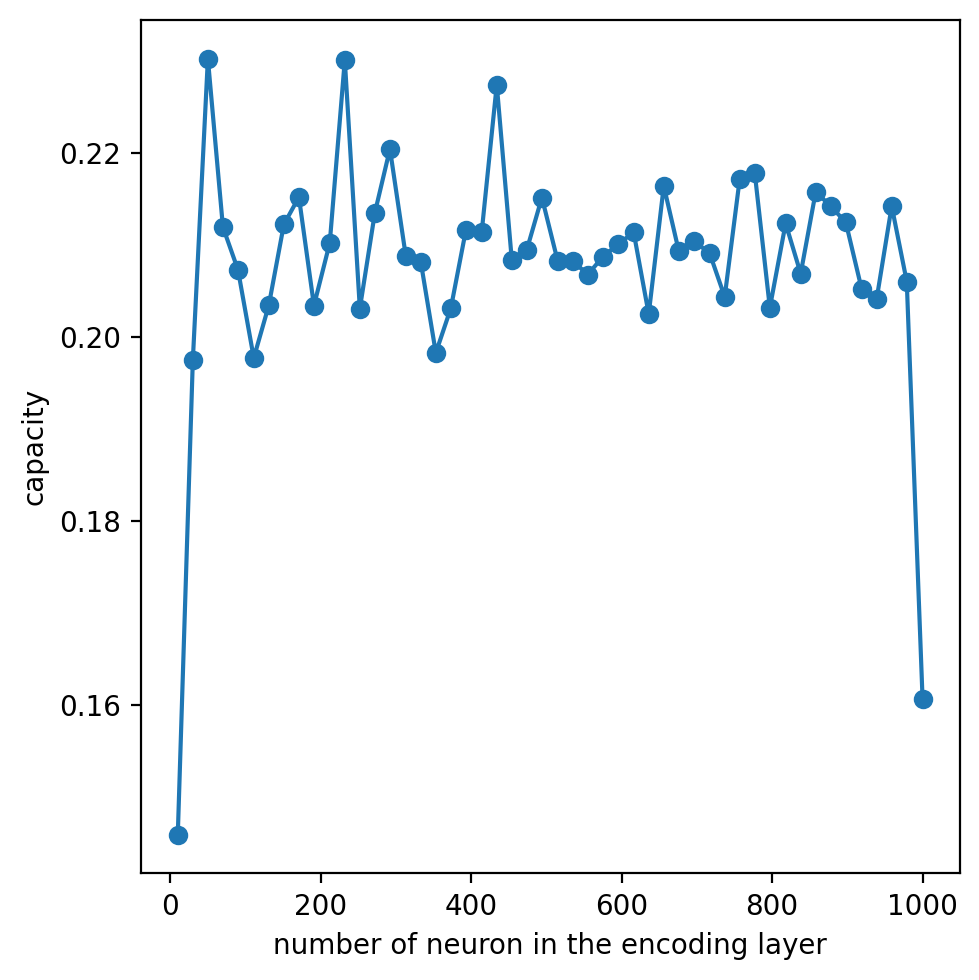

In [66]:
main_capacity = [np.load(os.path.join(results_fodler_name, "num_encneuron", f"main_capacity_numencneuron_{numEnc}.npy")).item() for numEnc in nEnc_range]

fig,ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(5,5),
    dpi=200
)

ax.plot(
    nEnc_range,
    main_capacity,
    marker="o"
)

ax.set_ylabel("capacity")
ax.set_xlabel("number of neuron in the encoding layer")

plt.tight_layout()
fig.savefig(os.path.join(results_fodler_name, "encoding_neuron_number__influence.pdf"), dpi=200)
plt.show()
